# CMA report

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.dataset import generate_datasets
from src.models import CMA
from src.report_functions import plot_stats, get_colors, generate_colors, run_pca, plot_scatter_2d, plot_scatter_3d, run_umap, kmeans_clustering
from src.functions import remap_confusion_matrix, score_vector

c:\Users\emend\anaconda3\envs\cma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_file = './checkpoint/clust_600.pth'
saving_prefix = 'stats/test'

In [3]:
checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))

# Load data
datasets = generate_datasets(suffix='5_diff', type='unpaired', train=True, test=False)
dataloaders = [DataLoader(ds, batch_size=checkpoint['config']['batch_size'], drop_last=False, shuffle=False) for ds in datasets]

n_clusters = len(datasets[0].classes)

Loading unpaired dataset


In [4]:
history = [entry for entry in checkpoint['history']]
mode = checkpoint['config']['mode']
num_modalities = len(checkpoint['models_names']['vae'])

#checkpoint['config']

## Statistics

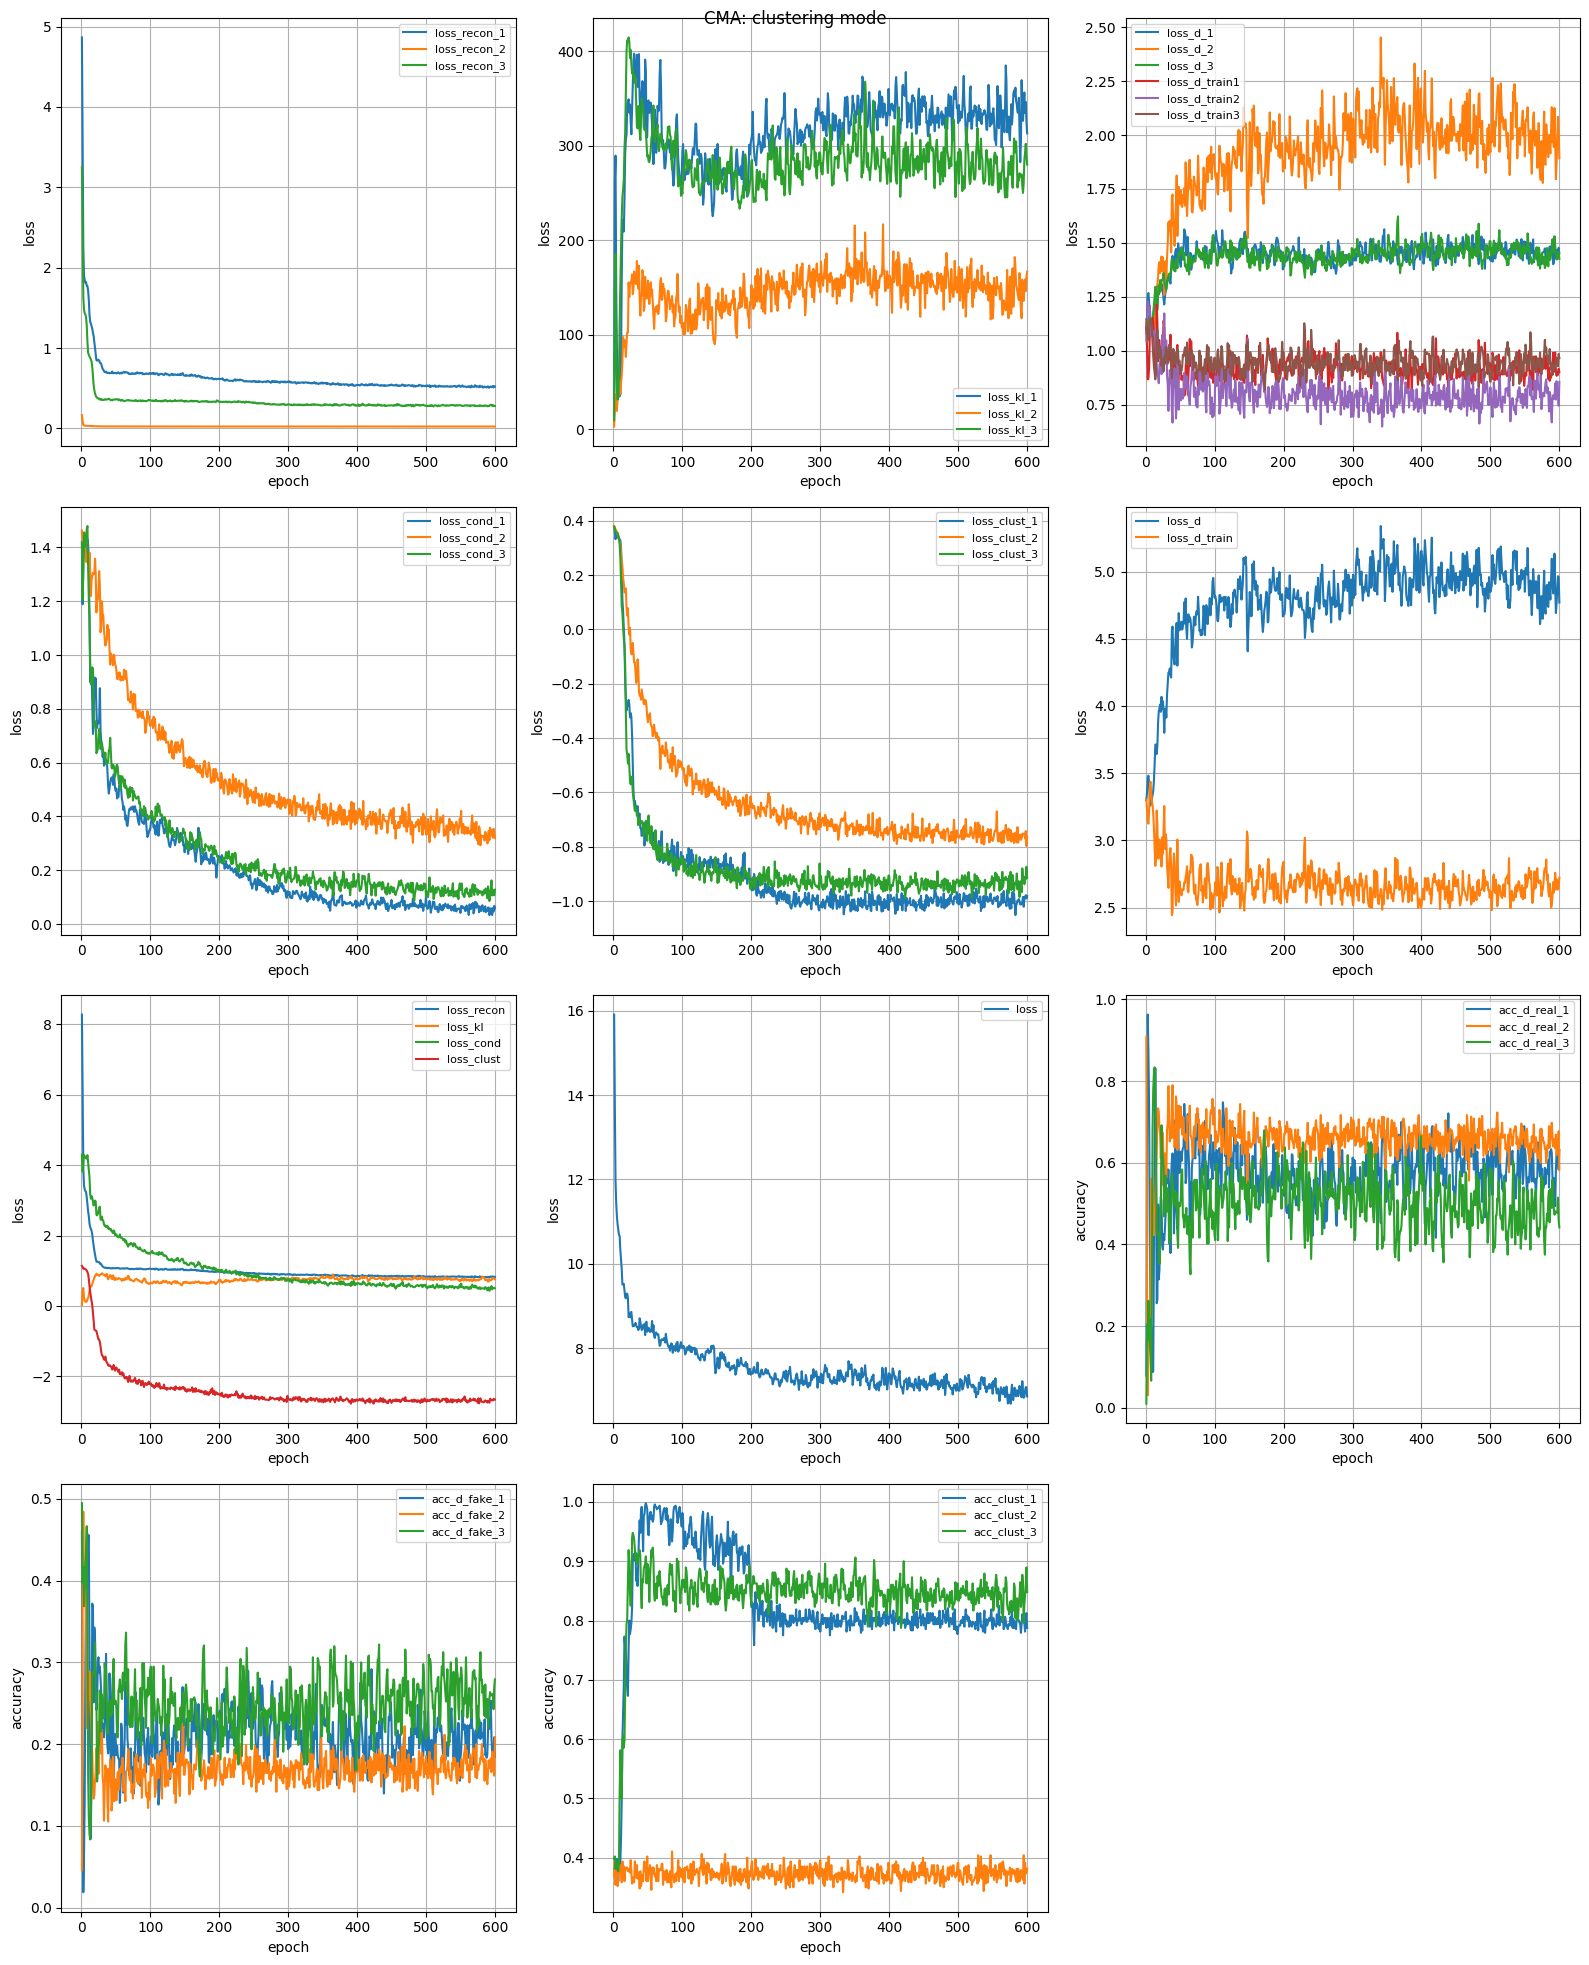

In [5]:
#plot_stats(mode, history, save_plot=True, filename=saving_prefix + '_stats')
plot_stats(mode, history)

## Plot latent space

### Prepare the data

In [6]:
#Modifs pour Zélie
cma = CMA()
device = torch.device('cpu')
cma.load(checkpoint_file, device=device)
# cma.load(checkpoint_file, checkpoint['config']['device'])

==> Pre-trained model loaded


In [7]:
def get_joined_latents_and_labels(dataloader, vae_model):
    latents = []
    labels = []
    pred_labels = []
    
    vae_model.eval()
    for X, y in dataloader:
        with torch.no_grad():
            vae_latents = vae_model.encoder(X.to(checkpoint['config']['device']))

        latents.append(vae_latents)
        labels.append(y)
        
        if mode == 'clustering':
            pred_clusters = torch.argmax(nn.functional.softmax(cma.model.cluster(cma.model.projector(vae_latents)), dim=1), axis=1)
            pred_labels.append(pred_clusters)
            
    conc_latents = torch.cat(latents, dim=0)
    conc_labels = torch.cat(labels, dim=0).cpu()
    
    if mode == 'clustering':
        conc_pred_labels = torch.cat(pred_labels, dim=0).cpu()
        acc, conf_mat, remapped_labels = remap_confusion_matrix(conc_labels, conc_pred_labels)
    
        return conc_latents, conc_labels, remapped_labels, acc, conf_mat # vae_latents, true_labels, pred_labels, pred_acc, confusion_matrix
    else:
        return conc_latents, conc_labels # vae_latents, true_labels

In [16]:
joined_data = list()
for i in range(len(dataloaders)):
    joined_data.append(get_joined_latents_and_labels(dataloaders[i], cma.model.vae[i]))
    
if mode == 'clustering':
    # Predicted named cluster labels
    pred_named_cluster_labels = [['cluster_' + str(n) for n in joined_data[i][2]] for i in range(len(joined_data))]

     # Predicted named labels per modality
    pred_named_labels = [['modal' + str(i) + '_' + str(n) for n in joined_data[i][2]] for i in range(len(joined_data))]

    # Concatenate pred labels
    conc_pred_labels = np.concatenate([joined_data[i][2] for i in range(len(joined_data))], axis=0).tolist()
    
    # Text labels
    conc_pred_named_cluster_labels = np.concatenate(pred_named_cluster_labels, axis=0).tolist()
    conc_pred_named_labels = np.concatenate(pred_named_labels, axis=0).tolist()

# Named cluster labels
pred_named_cluster_labels = [['cluster_' + str(n.numpy()) for n in joined_data[i][1]] for i in range(len(joined_data))]
    
# Named labels per modality
pred_named_labels = [['modal' + str(i) + '_' + str(n.numpy()) for n in joined_data[i][1]] for i in range(len(joined_data))]

# Concatenate

# Latents
conc_latents = torch.cat([joined_data[i][0] for i in range(len(joined_data))], dim=0).cpu()

# Numeric labels
conc_labels = torch.cat([joined_data[i][1] for i in range(len(joined_data))], dim=0).numpy().tolist()


conc_cluster_per_modal_labels = np.concatenate([joined_data[i][1]+(n_clusters*i) for i in range(len(joined_data))])


# Text labels

conc_named_cluster_labels = np.concatenate(pred_named_cluster_labels, axis=0).tolist()
conc_named_labels = np.concatenate(pred_named_labels, axis=0).tolist()

conc_named_cluster_per_modal_labels = []
for nc in conc_cluster_per_modal_labels:
    i = 1
    while True:
        if nc < n_clusters*i:
            conc_named_cluster_per_modal_labels.append('modal'+ str(i-1) + '_' + str(nc - (n_clusters*(i-1))))
            break
        i += 1
    
cluster_per_modal_mapping = {z for z in zip(conc_cluster_per_modal_labels, conc_named_cluster_per_modal_labels)}
cluster_per_modal_mapping = dict(cluster_per_modal_mapping)

# Colors

_colors_per_cluster  = np.array(get_colors(n_clusters))
_colors_per_modality = list(zip(*[generate_colors(c, num_modalities) for c in _colors_per_cluster]))

# Mapping for colors per cluster
unique_labels = sorted(set(conc_named_cluster_labels))
cluster_mapping = dict(zip(unique_labels, _colors_per_cluster))

# Mapping for colors clusters per modality
unique_labels = sorted(set(conc_named_labels))
sp = [n.split('_') for n in unique_labels]
modal, modal_cluster = list(zip(*sp))
_modal_mapping = dict(zip(sorted(set(modal)), list(range(len(set(modal))))))
_cluster_mapping = dict(zip(sorted(set(modal_cluster)), [int(n) for n in sorted(set(modal_cluster))]))
modal_mapping = {l:_colors_per_modality[_modal_mapping[m[0]]][_cluster_mapping[m[1]]] for l,m in zip(unique_labels, sp)}

#
cluster_colors = [cluster_mapping[label] for label in conc_named_cluster_labels]
modal_colors = [modal_mapping[label] for label in conc_named_labels]

if mode == 'clustering':
    pred_cluster_colors = [cluster_mapping[label] for label in conc_pred_named_cluster_labels]
    pred_modal_colors = [modal_mapping[label] for label in conc_pred_named_labels]

AssertionError: Torch not compiled with CUDA enabled

### PCA

Explained variance: [0.23495447 0.20189061]


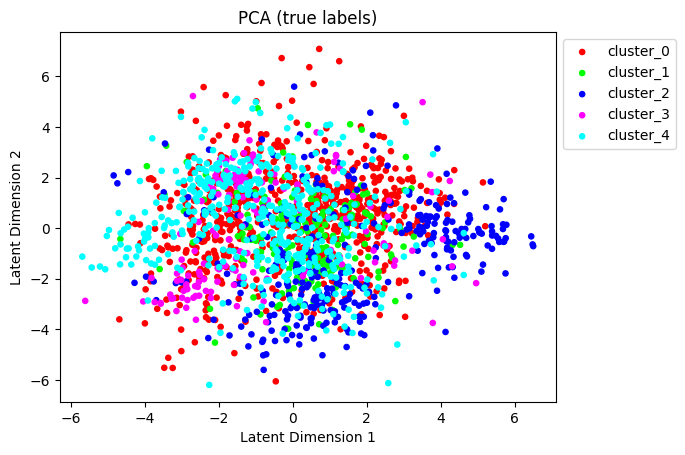

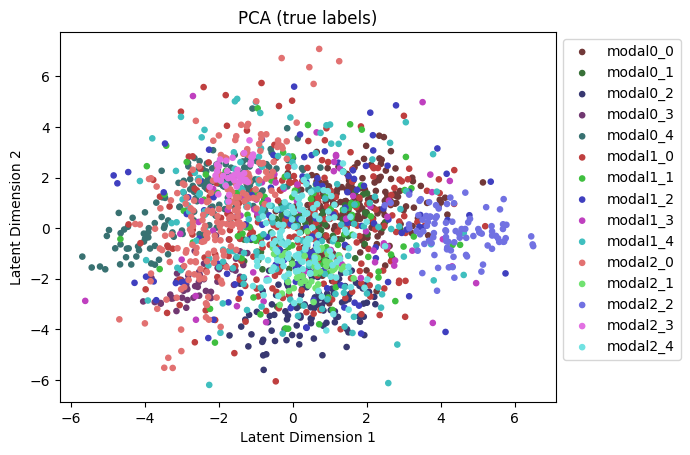

In [9]:
pca_data_2d, pca_expl_var = run_pca(conc_latents, '2d')
print('Explained variance:', pca_expl_var)

plot_scatter_2d(pca_data_2d, conc_named_cluster_labels, cluster_colors, 'PCA (true labels)')
plot_scatter_2d(pca_data_2d, conc_named_labels, modal_colors, 'PCA (true labels)')

#plot_scatter_2d(pca_data_2d, conc_named_cluster_labels, cluster_colors, 'PCA (true labels)', save_plot=True, filename=saving_prefix+'_pca_cluster_true_labels')
#plot_scatter_2d(pca_data_2d, conc_named_labels, modal_colors, 'PCA (true labels)', save_plot=True, filename=saving_prefix+'_pca_modal_true_labels')

### PCA 3D

In [10]:
pca_data_3d, pca_expl_var = run_pca(conc_latents, '3d')
print('Explained variance:', pca_expl_var)

plot_scatter_3d(pca_data_3d, conc_named_cluster_labels, cluster_colors, 'PCA (true labels)')
plot_scatter_3d(pca_data_3d, conc_named_labels, modal_colors, 'PCA (true labels)')

#plot_scatter_3d(pca_data_3d, conc_named_cluster_labels, cluster_colors, 'PCA (true labels)', as_gif=True, filename=saving_prefix + '_pca_3d_cluster_true_label')
#plot_scatter_3d(pca_data_3d, conc_named_labels, modal_colors, 'PCA (true labels)', as_gif=True, filename=saving_prefix + '_pca_3d_modal_true_label')

Explained variance: [0.23495447 0.20189061 0.18172378]


### UMAP

/home/daniel/miniconda3/envs/basic/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



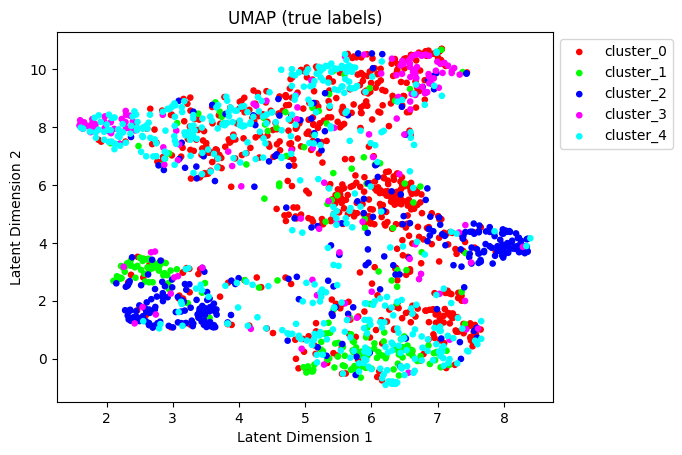

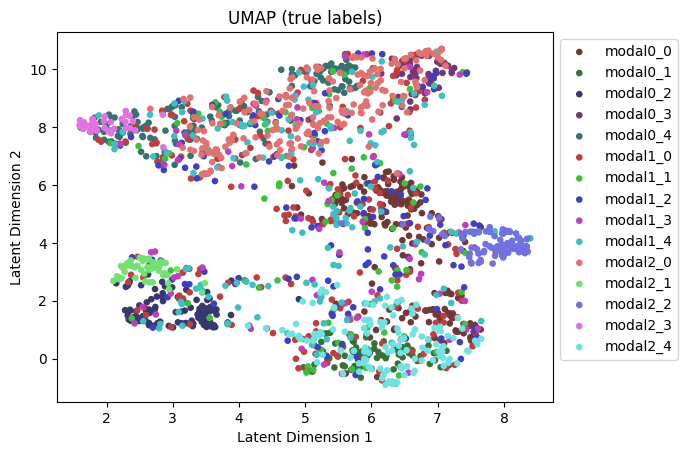

In [11]:
umap_data_2d = run_umap(conc_latents, type='2d')

plot_scatter_2d(umap_data_2d, conc_named_cluster_labels, cluster_colors, 'UMAP (true labels)')
plot_scatter_2d(umap_data_2d, conc_named_labels, modal_colors, 'UMAP (true labels)')

#plot_scatter_2d(umap_data_2d, conc_named_cluster_labels, cluster_colors, 'UMAP (true labels)', save_plot=True, filename=saving_prefix+'_umap_cluster_true_labels')
#plot_scatter_2d(umap_data_2d, conc_named_labels, modal_colors, 'UMAP (true labels)', save_plot=True, filename=saving_prefix+'_umap_modal_true_labels')

## Clustering module

Modality 1 accuracy: 0.7831125827814569


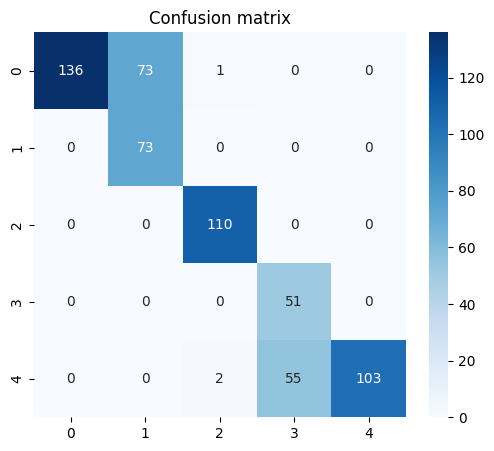


Modality 2 accuracy: 0.25075075075075076


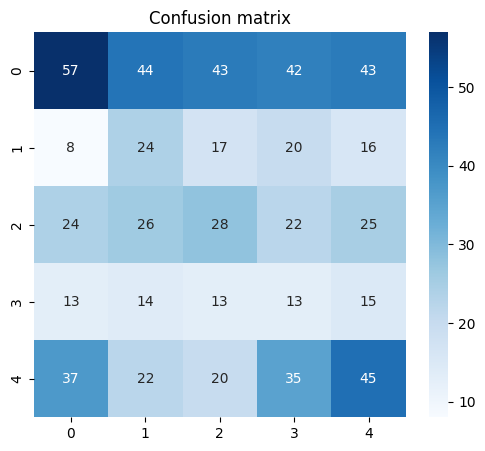


Modality 3 accuracy: 0.8133595284872298


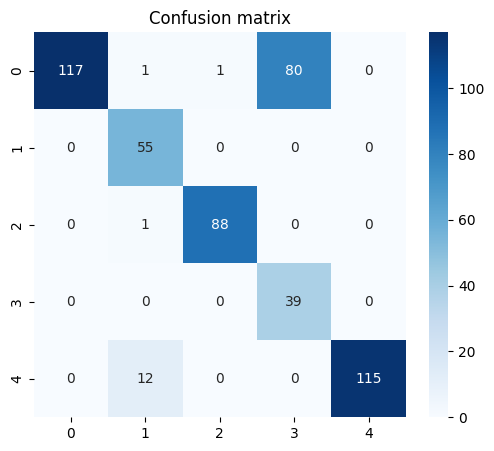

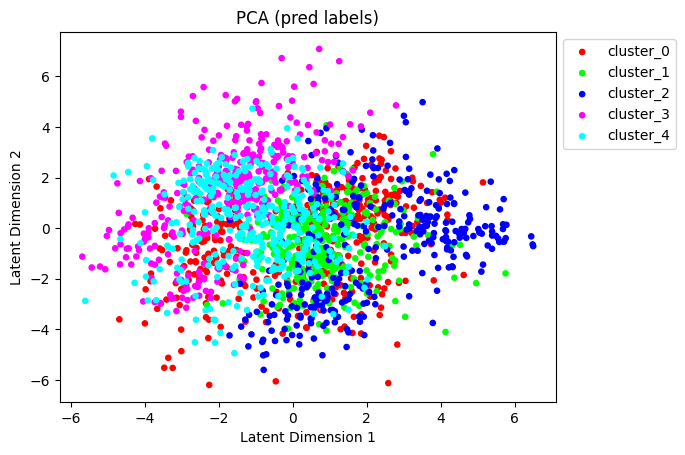

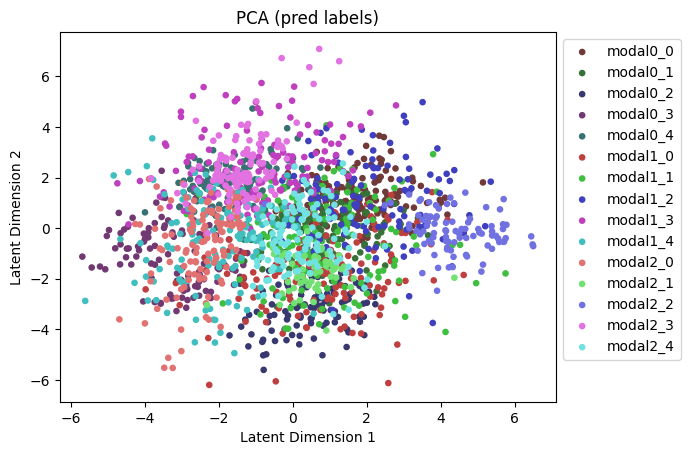

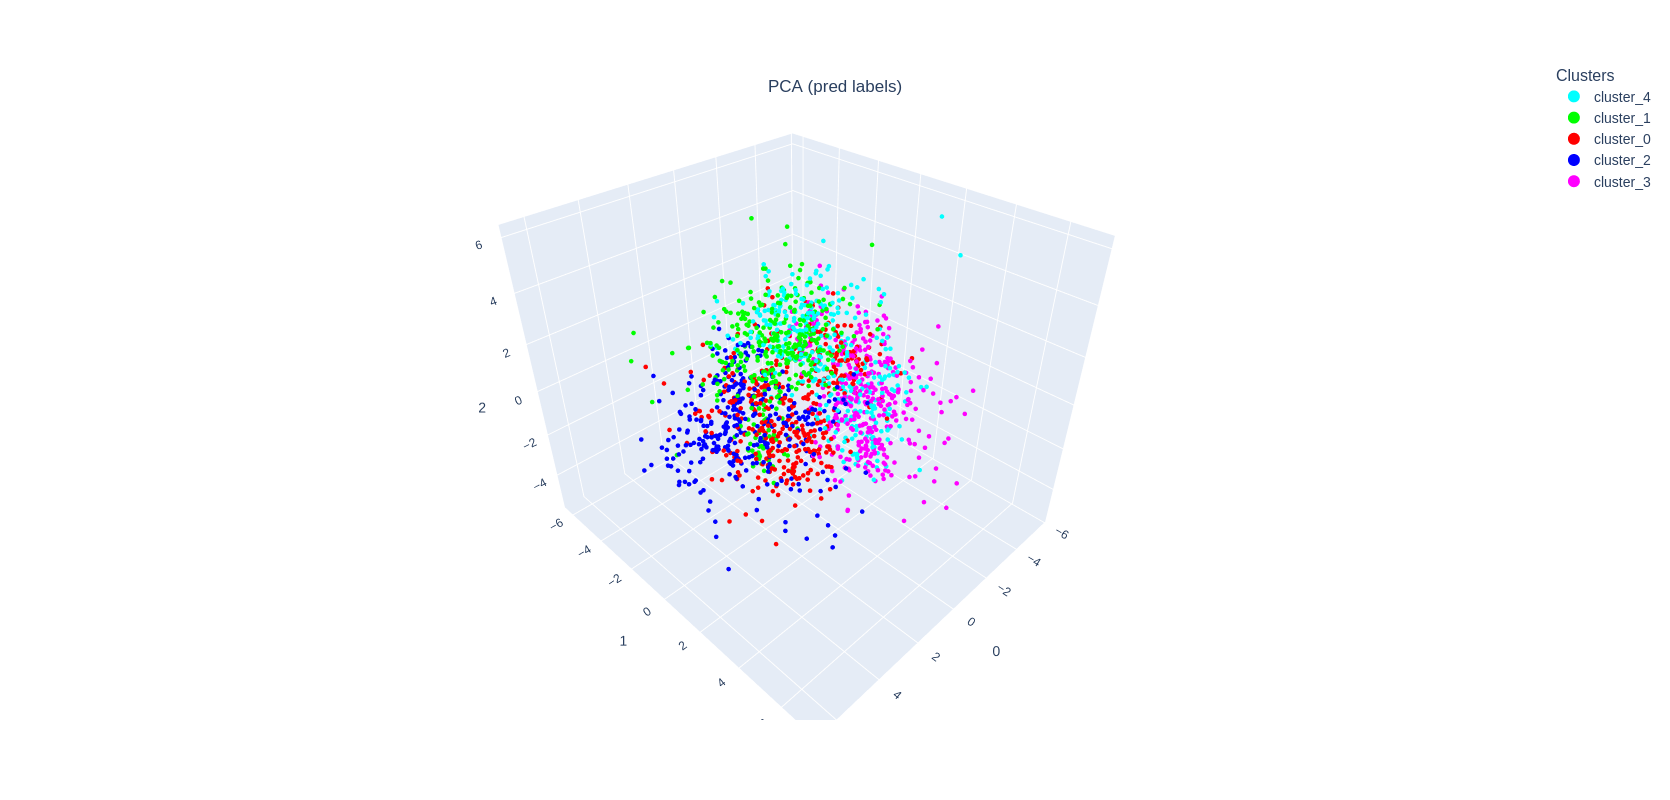

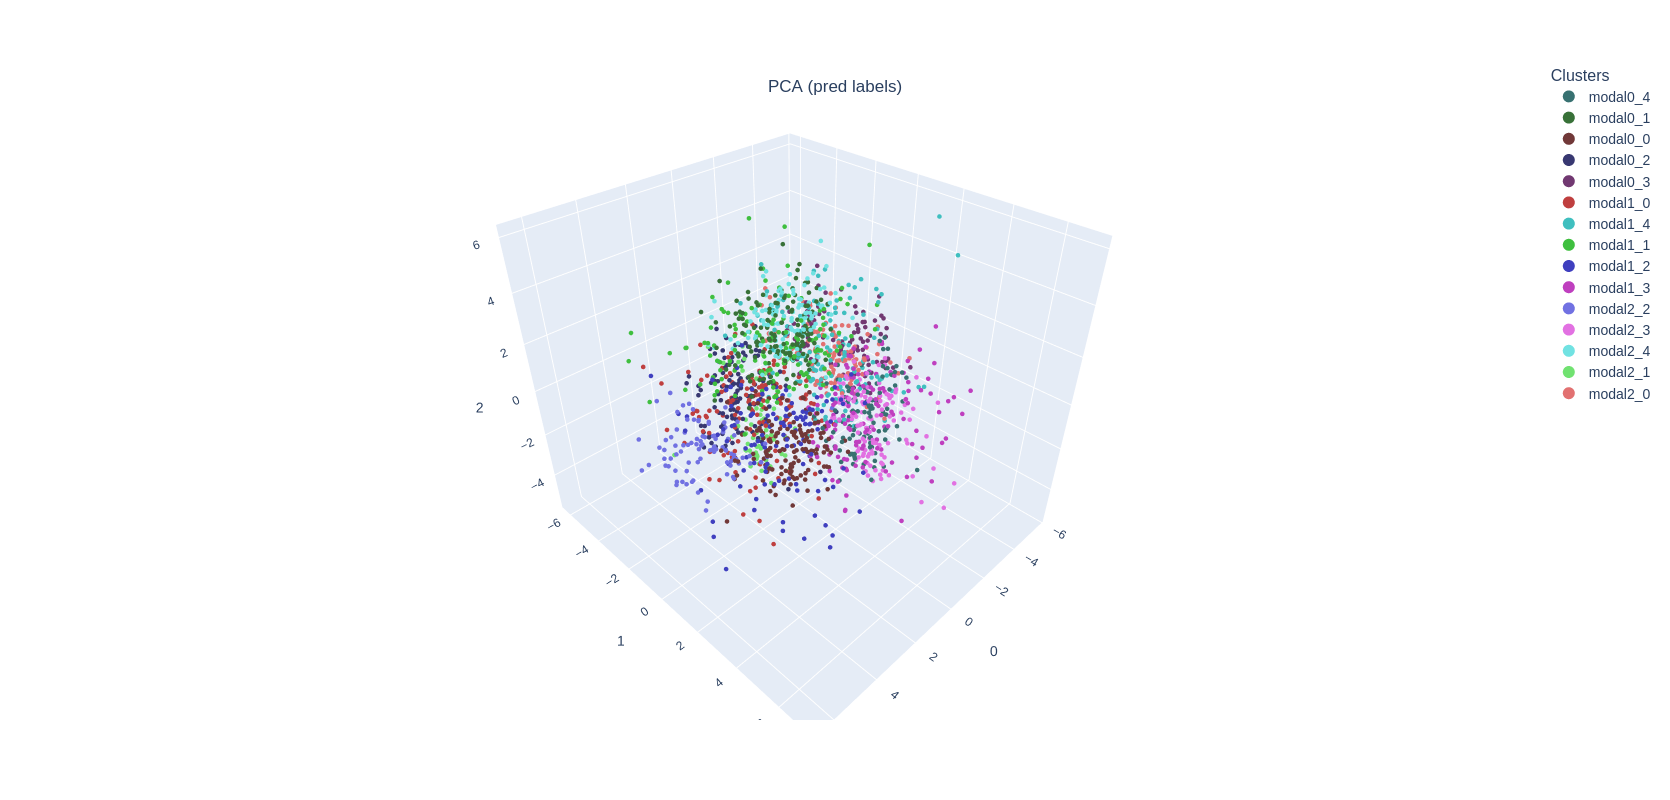

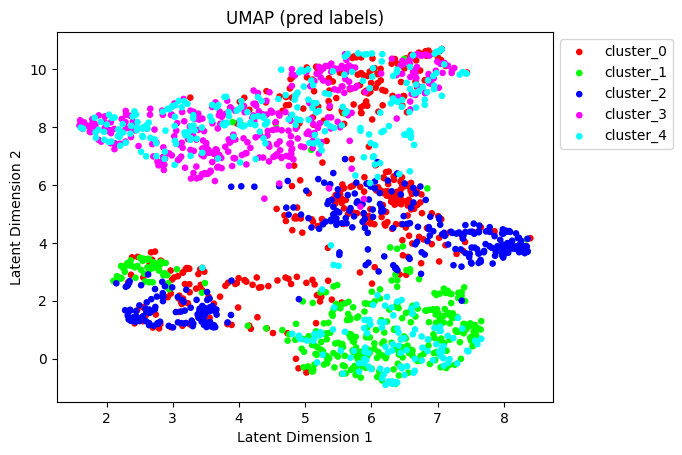

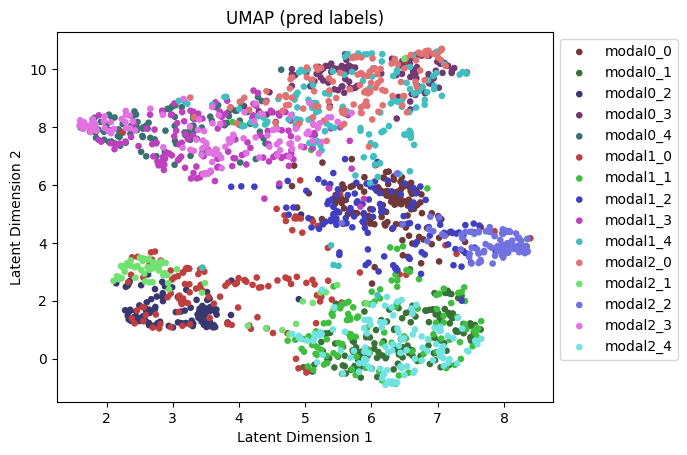

In [12]:
if mode == 'clustering':
    for i in range(len(joined_data)):
        if i > 0: print()
        print(f"Modality {i+1} accuracy: {joined_data[i][3]}") # pred_acc
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        sns.heatmap(joined_data[i][4], annot=True, fmt="d", cmap="Blues", ax=axes) # confusion_matrix
        axes.set_title("Confusion matrix")
        plt.show()

    # PCA
    
    plot_scatter_2d(pca_data_2d, conc_pred_named_cluster_labels, pred_cluster_colors, 'PCA (pred labels)')
    plot_scatter_2d(pca_data_2d, conc_pred_named_labels, pred_modal_colors, 'PCA (pred labels)')

    #plot_scatter_2d(pca_data_2d, conc_pred_named_cluster_labels, pred_cluster_colors, 'PCA (pred labels)', save_plot=True, filename=saving_prefix+'_pca_cluster_pred_labels')
    #plot_scatter_2d(pca_data_2d, conc_pred_named_labels, pred_modal_colors, 'PCA (pred labels)', save_plot=True, filename=saving_prefix+'_pca_modal_pred_labels')

    # PCA 3D

    plot_scatter_3d(pca_data_3d, conc_pred_named_cluster_labels, pred_cluster_colors, 'PCA (pred labels)')
    plot_scatter_3d(pca_data_3d, conc_pred_named_labels, pred_modal_colors, 'PCA (pred labels)')

    # UMAP

    plot_scatter_2d(umap_data_2d, conc_pred_named_cluster_labels, pred_cluster_colors, 'UMAP (pred labels)')
    plot_scatter_2d(umap_data_2d, conc_pred_named_labels, pred_modal_colors, 'UMAP (pred labels)')
    
    #plot_scatter_2d(umap_data_2d, conc_pred_named_cluster_labels, pred_cluster_colors, 'UMAP (pred labels)', save_plot=True, filename=saving_prefix+'_umap_cluster_pred_labels')
    #plot_scatter_2d(umap_data_2d, conc_pred_named_labels, pred_modal_colors, 'UMAP (pred labels)', save_plot=True, filename=saving_prefix+'_umap_modal_pred_labels')

## K-means clustering

K-means accuracy: 0.3490725126475548
Jaccard Index (JI): 0.20793932304373275
Adjusted Rand Index (ARI): 0.0718431499928135


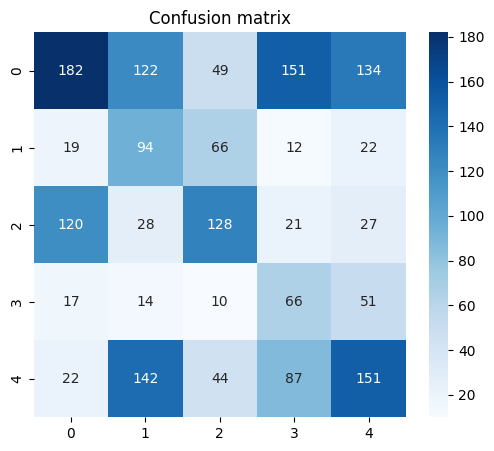

In [13]:
kmeans_acc, kmeans_cm, kmeans_labels = kmeans_clustering(conc_latents, n_clusters, conc_labels)
print(f"K-means accuracy: {kmeans_acc}")

score_vector(conc_labels, kmeans_labels)

fig, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(kmeans_cm, annot=True, fmt="d", cmap="Blues", ax=axes)
axes.set_title("Confusion matrix")
plt.show()
#plt.savefig(saving_prefix+'_conf_mat_cluster_kmeans.png', bbox_inches='tight', dpi=100)

# Colors
kmeans_named_labels = ['cluster_' + str(n) for n in kmeans_labels]
kmeans_colors = [cluster_mapping[label] for label in kmeans_named_labels]

plot_scatter_3d(pca_data_3d, conc_named_cluster_labels, cluster_colors, 'PCA (true labels)')
plot_scatter_3d(pca_data_3d, kmeans_named_labels, kmeans_colors, 'PCA (kmeans labels)')

K-means accuracy: 0.35132096683530073
Jaccard Index (JI): 0.23701051100371734
Adjusted Rand Index (ARI): 0.18813600872931877


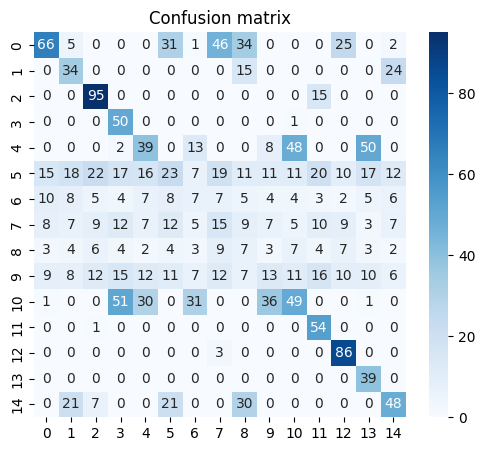

In [14]:
kmeans_acc, kmeans_cm, kmeans_labels = kmeans_clustering(conc_latents, len(set(conc_cluster_per_modal_labels)), conc_cluster_per_modal_labels)
print(f"K-means accuracy: {kmeans_acc}")

score_vector(conc_cluster_per_modal_labels, kmeans_labels)

fig, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(kmeans_cm, annot=True, fmt="d", cmap="Blues", ax=axes)
axes.set_title("Confusion matrix")
plt.show()
#plt.savefig(saving_prefix+'_conf_mat_modal_kmeans.png', bbox_inches='tight', dpi=100)

# Colors
kmeans_named_labels = [cluster_per_modal_mapping[l] for l in kmeans_labels]
kmeans_colors = [modal_mapping[label] for label in kmeans_named_labels]

plot_scatter_3d(pca_data_3d, conc_named_labels, modal_colors, 'PCA (true labels)')
plot_scatter_3d(pca_data_3d, kmeans_named_labels, kmeans_colors, 'PCA (kmeans labels)')

## 